# TASK1

In [1]:
from __future__ import print_function, division

import thinkdsp
import thinkplot
import thinkstats2

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

%matplotlib inline

In [2]:
wave = thinkdsp.read_wave('task1.wav')
wave.make_audio()

Звук волн черного моря; Выберем небольшой сегмент:

In [3]:
segment = wave.segment(start=1.5, duration=1.0)
segment.make_audio()

Отобразим спектр:

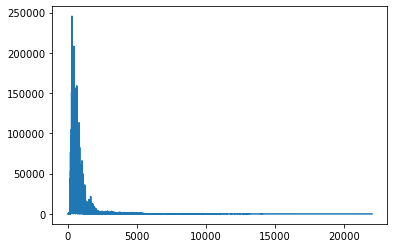

In [4]:
spectrum = segment.make_spectrum()
spectrum.plot_power()

Амплитуда падает с частотой, поэтому это может быть красный или розовый шум. Мы можем проверить это, посмотрев на спектр мощности в логарифмической шкале.

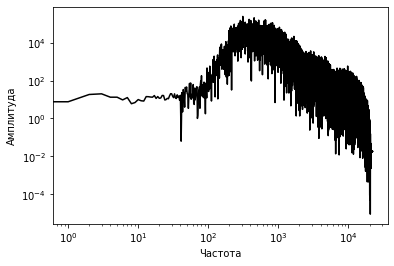

In [25]:
spectrum.plot_power(color = 'black')
loglog = dict(xscale='log', yscale='log')
thinkplot.config(xlabel='Частота', ylabel='Амплитуда', xscale = 'log', yscale = 'log')

Амплитуда этой структуры сначала увеличивается, а затем уменьшается. Это обычное явлением для естественных источников шума. Выберем другой отрезок:

In [14]:
segment2 = wave.segment(start=2.5, duration=1.0)
segment2.make_audio()

Отобразим спектр этих 2 сегментов:

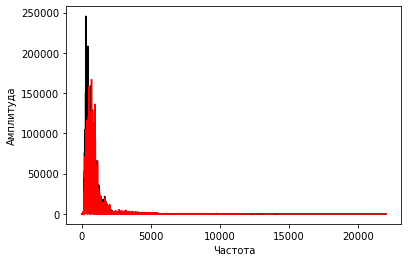

In [21]:
spectrum2 = segment2.make_spectrum()
spectrum.plot_power(color = 'black')
spectrum2.plot_power(color ='red')
thinkplot.config(xlabel='Частота', ylabel='Амплитуда')

Рассмотрим их в логарифмической метрики:

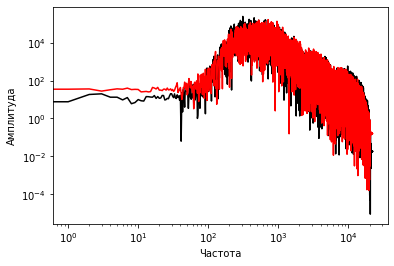

In [28]:
spectrum.plot_power(color = 'black')
spectrum2.plot_power(color ='red')
thinkplot.config(xlabel='Частота', ylabel='Амплитуда', xscale='log', yscale='log')

Из данного сравнения мы можем заметить что поведение данной структуры остается практически неизменным с течением времени.

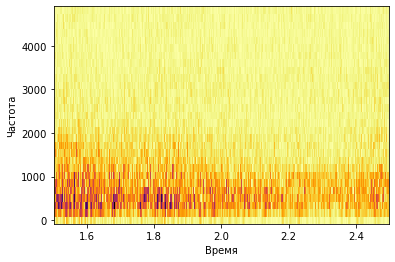

In [35]:
segment.make_spectrogram(256).plot(high=5000)
thinkplot.config(xlabel='Время', ylabel='Частота')

В этом сегменте общая амплитуда падает, но смесь частот кажется стабильной.

# TASK2

bartlett_method создает спектрограмму и извлекает spec_map, который отображает время на объекты Spectrum. Он вычисляет PSD для каждого спектра, складывает их и помещает результаты в объект Spectrum.

In [36]:
from thinkdsp import Spectrum

def bartlett_method(wave, seg_length=512, win_flag=True):
    spectro = wave.make_spectrogram(seg_length, win_flag)
    spectrums = spectro.spec_map.values()
    
    psds = [spectrum.power for spectrum in spectrums]
    
    hs = np.sqrt(sum(psds) / len(psds))
    fs = next(iter(spectrums)).fs
    
    spectrum = Spectrum(hs, fs, wave.framerate)
    return spectrum

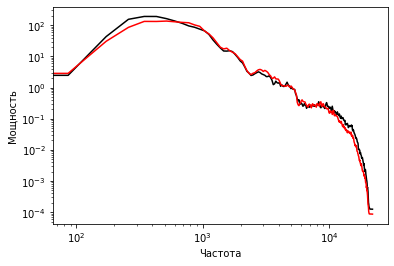

In [39]:
psd = bartlett_method(segment)
psd2 = bartlett_method(segment2)
psd.plot_power(color = 'black')
psd2.plot_power(color ='red')
thinkplot.config(xlabel='Частота', ylabel='Мощность', xscale='log', yscale='log')

Теперь мы можем более четко увидеть взаимосвязь между мощностью и частотой. Это не простая линейная зависимость, но она одинакова для разных сегментов, даже в деталях, таких как выемки около 1000 Гц, 4000 Гц и тд..

# TASK3

In [48]:
import pandas as pd

res = pd.read_csv('task3.csv', parse_dates=[0])
res

Currency        Date  Closing Price (USD)  24h Open (USD)  24h High (USD)  \
0        BTC  2020-01-02          7174.744012     7179.957689     7237.014866   
1        BTC  2020-01-03          6955.487580     7174.712357     7190.188749   
2        BTC  2020-01-04          7291.219505     6955.487580     7390.041835   
3        BTC  2020-01-05          7337.636670     7291.217504     7390.762935   
4        BTC  2020-01-06          7347.433264     7337.421391     7487.333871   
..       ...         ...                  ...             ...             ...   
362      BTC  2020-12-29         26718.029463    26226.066130    27447.551384   
363      BTC  2020-12-30         26975.729565    27038.735676    27169.225558   
364      BTC  2020-12-31         28768.836208    27349.327233    28928.214391   
365      BTC  2021-01-01         29111.521567    28872.829775    29280.045328   
366      BTC  2021-01-02         29333.605121    28935.810981    29601.594898   

     24h Low (USD)  
0      7152.992402  
1      6914.857474  
2      6852.093401  
3      7263.178696  
4      7316.763370  
..             ...  
362   26046.625578  
363   25875.049786  
364   27349.283204  
365   27916.625059  
366   28753.412314  

[367 rows x 6 columns]

Выгрузка даты об изменении цены на биткоин в долларх в период с 1 января 2020 по 1 января 2021

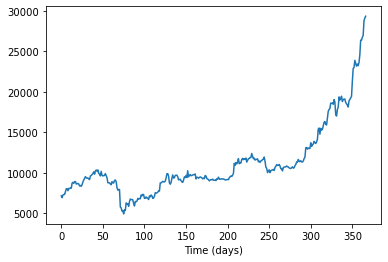

In [49]:
wave = thinkdsp.Wave(data['Closing Price (USD)'], data.index, framerate=1)
wave.plot()
thinkplot.config(xlabel='Time (days)')

Построим спектр, где частотa ~ 1/дни.

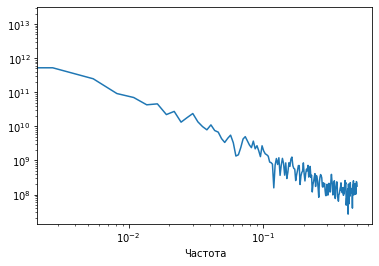

In [52]:
spectrum = wave.make_spectrum()
spectrum.plot_power()
thinkplot.config(xlabel='Частота', xscale='log', yscale='log')

In [53]:
spectrum.estimate_slope()[0]

-1.740740204158508

Красный шум должен иметь наклон -2. Наклон этого спектра близок к -1,7, сложно сделать вывод о принадлежности его к розовому или красному шумам.

# TASK4

Реализуем класс, UncorrelatedPoissonNoise, который наследуется от _Noise и обеспечивает оценку. Он должен использовать np.random.poisson для генерации случайных значений из распределения Пуассона. Параметр этой функции lam - среднее количество частиц за каждый интервал. Вы можете использовать атрибут amp, чтобы указать lam. Например, если частота кадров составляет 10 кГц, а ампер - 0,001, мы ожидаем около 10 «щелчков» в секунду.

In [54]:
class UncorrelatedPoissonNoise(thinkdsp.Noise):
    def evaluate(self, ts):
        ys = np.random.poisson(self.amp, len(ts))
        return ys

Звук при низком уровне радиации

In [58]:
amp = 0.001
framerate = 10000
duration = 1

signal = UncorrelatedPoissonNoise(amp=amp)
wave = signal.make_wave(duration=duration, framerate=framerate)
wave.make_audio()

Чтобы убедиться, что все работает, мы сравниваем ожидаемое количество частиц и фактическое количество:

In [59]:
expected = amp * framerate * duration
actual = sum(wave.ys)
print(expected, actual)

10.0 10


Рассмотрим волну:

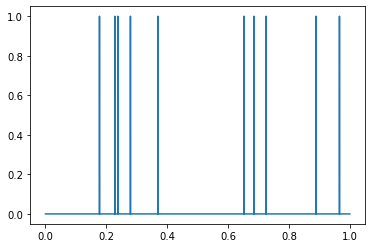

In [60]:
wave.plot()

Также рассмотрим спектр мощности в логарифмической метрики:

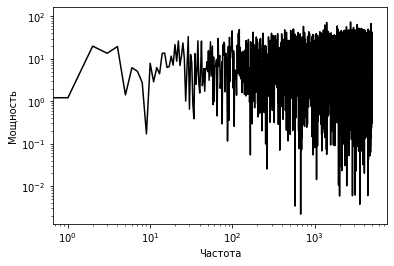

In [61]:
spectrum = wave.make_spectrum()
spectrum.plot_power(color = 'black')
thinkplot.config(xlabel='Частота', ylabel='Мощность', xscale='log',  yscale='log')

In [62]:
spectrum.estimate_slope().slope

0.0018917076197293935

Наклон составляет 0.0019, что практически соотвестувует белому шуму.

In [64]:
amp = 1
framerate = 10000
duration = 1

signal = UncorrelatedPoissonNoise(amp=amp)
wave = signal.make_wave(duration=duration, framerate=framerate)
wave.make_audio()

Отобразим на графике: 

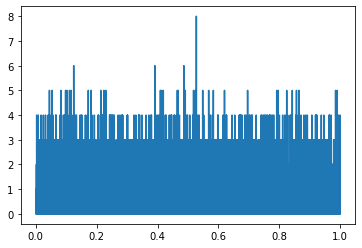

In [65]:
wave.plot()

И спектр сходится на гауссовском шуме.

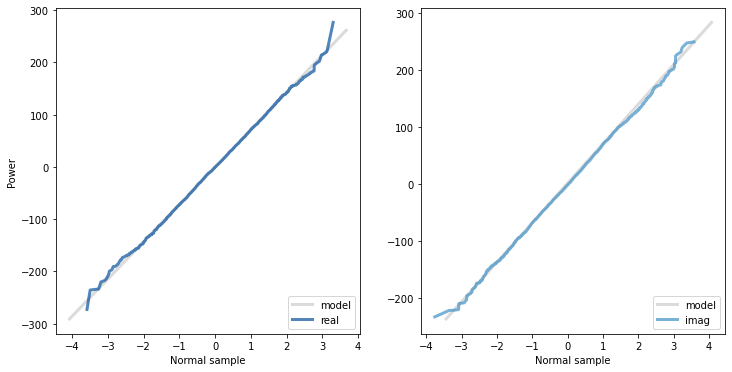

In [74]:
spectrum = wave.make_spectrum()
spectrum.hs[0] = 0

thinkplot.preplot(2, cols=2)
thinkstats2.NormalProbabilityPlot(spectrum.real, label='real')
thinkplot.config(xlabel='Normal sample', ylabel='Power', legend=True)

thinkplot.subplot(2)
thinkstats2.NormalProbabilityPlot(spectrum.imag, label='imag')
thinkplot.config(xlabel='Normal sample')

# TASK5

Алгоритм, описанный в этой главе, для генерации розового шума концептуально прост, но требует больших вычислительных ресурсов. Есть более эффективные альтернативы, такие как алгоритм Восса-Маккартни. 

In [94]:
def voss(nrows, ncols=16):
    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)

    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = df.sum(axis=1)

    return total.values

Для проверки сгенерирую 10000 значений 

In [96]:
gen = voss(10000)
gen

array([7.43336077, 8.31916604, 8.25946949, ..., 9.26148084, 8.91716615,
       8.4883063 ])

Сгенерируем сигнал с помощью этих значений:

In [97]:
wave = thinkdsp.Wave(gen)
wave.unbias()
wave.normalize()

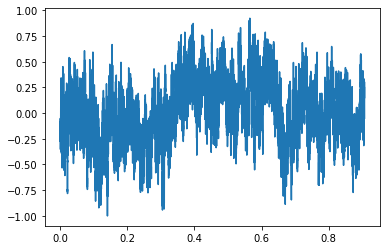

In [98]:
wave.plot()

Прослушаем данный сигнал:

In [100]:
wave.make_audio()

Из графика этого сигнала мы понимаем что это не похоже на белый шум

Построим спект мощности:

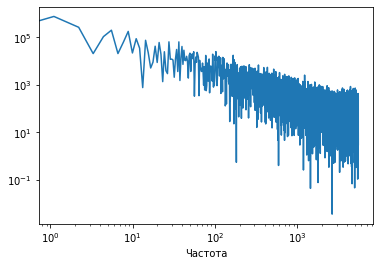

In [101]:
spectrum = wave.make_spectrum()
spectrum.hs[0] = 0
spectrum.plot_power()
thinkplot.config(xlabel='Частота', xscale='log', yscale='log')

In [102]:
spectrum.estimate_slope().slope

-1.0197331142428645

Отобразив наклон мы видим что он близок к -1. Для более лучшего понимания среднего спектра мощности мы должны сгенерировать более длинную выборку

In [103]:
seg_length = 64 * 1024
iters = 100
wave = Wave(voss(seg_length * iters))
len(wave)

6553600

In [104]:
spectrum = bartlett_method(wave, seg_length=seg_length, win_flag=False)
spectrum.hs[0] = 0
len(spectrum)

32769

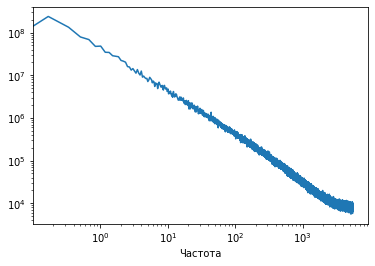

In [105]:
spectrum.plot_power()
thinkplot.config(xlabel='Частота', xscale='log', yscale='log')

In [106]:
spectrum.estimate_slope().slope

-1.0017682125992708

Это довольно близко к прямой линии с некоторой кривизной на самых высоких частотах. Наклон близок к -1